In [63]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("cdc_clean_carefully_dropped_missing.csv")
df.head()

,cnty_fips,county,state,cardiac_intensive_care_units,cardiac_rehab_eligibility,cardiac_rehab_sessions,cardiac_rehab_particpation,cardiac_rehab_units,cholesterol_screen,cholesterol_medication,...,population_black,population_hispanic,population_total,population_white,income_inequality,median_houshld_income,park_access,poverty_rate,unemployment_rate,urban_rural_class
0,2020,Anchorage,AK,1.0,13.5,23.6,24.3,1.0,72.5,18.7,...,5.2,9.1,293531.0,57.9,0.430,0.430,83.0,9.5,4.4,3.0
1,2090,Fairbanks North Star,AK,1.0,13.0,29.6,33.6,1.0,70.8,17.1,...,4.2,8.0,99072.0,69.9,0.409,0.409,36.0,7.2,4.7,3.0
2,2122,Kenai Peninsula,AK,0.0,15.3,25.7,33.6,1.0,75.4,18.8,...,0.5,4.1,58464.0,79.9,0.439,0.439,52.0,10.4,6.0,4.0
3,2170,Matanuska-Susitna,AK,0.0,15.3,24.1,22.7,0.0,72.3,17.6,...,1.1,4.9,105369.0,79.2,0.422,0.422,26.0,9.6,6.1,3.0
4,6001,Alameda,CA,3.0,10.6,26.2,23.6,6.0,80.8,13.8,...,10.3,22.3,1656754.0,31.4,0.462,0.462,84.0,8.9,3.0,1.0


Selecting variables of interest for EDA

In [3]:
df = df[["prevalence", "cholesterol_awareness", "diagnosed_diabetes", "obesity",  "leisure_inactivity", "smoking", \
        "cardiac_rehab_eligibility", "cholesterol_medication", "cholesterol_screen", "cardiac_rehab_sessions", \
         "cardiac_rehab_particpation", "cardiac_rehab_units", "total_healthcare_cost_per_capita", \
         "air_quality", "park_access", "population_age_65_plus", "population_total", "urban_rural_class", \
         "median_houshld_income", "poverty_rate"]]

**Split the data into test and train sets**

In [49]:
X = df.drop("prevalence", axis = 1)
y = df["prevalence"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
#### Normalize the training set.

def scaler_function(data):
  
    #Sclaing our data for the univariate mode
    scaler = StandardScaler()
    scaler.fit(data)
    data = scaler.transform(data)
  
    return data

X_train_scaled = scaler_function(X_train)
X_test_scaled = scaler_function(X_test)
# y_train_scaled = scaler_function(pd.DataFrame(y_train))
# y_test_scaled = scaler_function(pd.DataFrame(y_test))

**Dimensionality Reduction with Principal Components Analysis**

Reference https://towardsdatascience.com/principal-component-analysis-pca-with-scikit-learn-1e84a0c731b0

In [19]:
from sklearn.decomposition import PCA

In [20]:
n_cols = X_train.shape[1]
pca = PCA(n_components = n_cols, random_state = 42)
pca.fit(X_train_scaled)
print("percent variance explained by principal components:")
pca.explained_variance_ratio_ * 100
# check  (uncommnet to confirm that the sum of percentage variance explained by all the principal components is 100%)
#sum(pca_5.explained_variance_ratio_* 100)
pd.DataFrame((pca.explained_variance_ratio_  *100), columns = ["percent explained variance"], \
             index = ["PC" + str(i+1) for i in range(n_cols )])

percent variance explained by principal components:


,percent explained variance
PC1,27.303296
PC2,15.731304
PC3,9.326657
PC4,7.733268
PC5,5.811532
PC6,5.344981
PC7,4.668847
PC8,3.960581
PC9,3.436981
PC10,2.734057


In [21]:
print("cumulative sum of principal components:")
np.cumsum(pca.explained_variance_ratio_ * 100)
pd.DataFrame(np.cumsum(pca.explained_variance_ratio_ * 100), columns = ["cumulative percent variance explained"], \
             index = ["PC" + str(i+1) for i in range(n_cols )])

cumulative sum of principal components:


,cumulative percent variance explained
PC1,27.303296
PC2,43.034601
PC3,52.361257
PC4,60.094525
PC5,65.906057
PC6,71.251038
PC7,75.919885
PC8,79.880466
PC9,83.317447
PC10,86.051504


We see from the above table that 12  Principal Components account for 90 percent of the varaiations in the data. While this is not much of  reduction of the dimensions, we will fit a linear regression model with the first 12 principal components and evaluate the performance in comparison with the regular and lasso models.

Text(0, 0.5, 'Explained variance')

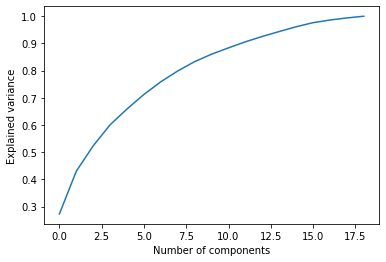

In [22]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Explained variance")

Given the above information, we can remodel the PCA to capture 90% of the variability in the data by setting n_components = 0.90. Notice that the result sould yield four principal components.

In [74]:
pca_90 = PCA(n_components = 0.90, random_state = 2020)
pca_90.fit(X_train_scaled)
X_train_pca = pca_90.transform(X_train_scaled)

X_train_pca.shape

(1848, 12)

Notice that 12 principal components are captured.

Now we can fit a regression model to this dataset.

In [75]:
from sklearn import linear_model

# train model
pca_model = linear_model.LinearRegression()
pca_model.fit(X_train_pca, y_train)          

pca_model.coef_

array([-0.54036824, -0.29643643,  0.54807996,  0.33001816,  0.19346162,
        0.06147791,  0.10657783, -0.18505045,  0.09746657,  0.30441384,
        0.05067826, -0.01071785])

In [76]:
# evaluate model

In [77]:
# transform X_test set to principal componemts equivalance.
X_test_pca = pca_90.transform(X_test_scaled)

r_squared = pca_model.score(X_test_pca, y_test)                       # R^2

y_predicted = pca_model.predict(X_test_pca)

test_error = mean_squared_error(y_test, y_predicted, squared=False)      # Root Mean Sqaured Error


print('R-squared' + ":", round(r_squared, 4))
print("predcition error:", round(test_error, 6))


R-squared: 0.8889
predcition error: 0.500911


This model performs worst than non-pca models. Understandably, this model does not account for all the variance in the data.